In [231]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools
%matplotlib inline

In [232]:
def print_G(G):
    import pylab
    pos = nx.spring_layout(G)  # positions for all nodes

    nx.draw(G,pos)
    
    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(G, pos, width=2)
    
# specifiy edge labels explicitly
    edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)

    nx.draw_networkx_labels(G, pos, font_size=20
                            , font_family='sans-serif'
                            ,edge_labels=nx.get_edge_attributes(G,'weight').values)

    
    pylab.show()

In [233]:
class RPQ:
    def __init__(self):
        cols_df = ['current_node','distance_from_start','prev_node','time_joined','time']
        self.df = pd.DataFrame(columns=cols_df)
        
        cols_df_visited = ['time','nodes_visited']
        self.df_visited = pd.DataFrame(columns=cols_df_visited)
        
        self.df.loc[len(self.df)] = ['s',0,'s',0,0]
        self.df_visited.loc[len(self.df_visited)] = [0,np.array([])]
        self.visited = []
        self.time = 0
    
    def add_visited(self,node):
        if node not in rpq.visited:
            self.visited.append(node)
        
    def update_visited_nodes(self):
        self.df_visited.loc[len(self.df_visited)]=[self.time,str(self.visited).translate(None, "[] '").split(',')]

    def increase_time(self):
        self.time = self.time + 1
       
    def insert(self,row):
        self.df.loc[len(self.df)]=row
        self.df = (self.df
                   .sort_values(['time','distance_from_start','time_joined'],ascending=[False,True,True])
                   .reset_index()
                   .drop('index',axis=1)
                  )
    
    def de_dup(self):
        self.df = self.df.drop_duplicates(subset = ['current_node','time'])
    
    def add_timestep(self):
        max_time = self.df.time.max()
        temp = self.df[self.df.time == max_time][1:]
        temp.time = self.time
        self.df = (self.df.append(temp)
                   .sort_values(['time','distance_from_start','time_joined'],ascending=[False,True,True])
                  )
        
        
    def pop_current_node(self):
        temp_df = self.df[(self.df.time==self.df.time.max())]
        temp_df = temp_df[~temp_df.current_node.isin(self.visited)]
        ret = temp_df.current_node.iloc[0]
        current_tot_weight = temp_df.distance_from_start.iloc[0]
        #self.df = self.df.iloc[1:]
        return ret,current_tot_weight
    


In [234]:
# temp_df = rpq.df[(rpq.df.time==rpq.time)]
# temp_df = temp_df[~temp_df.current_node.isin(self.visited)]
# ret = temp_df.current_node.iloc[0]
# current_tot_weight = temp_df.distance_from_start.iloc[0]

In [249]:
temp_df = rpq.df[(rpq.df.time==rpq.df.time.max())]
#temp_df = temp_df[~temp_df.current_node.isin(rpq.visited)]

In [250]:
temp_df

,current_node,distance_from_start,prev_node,time_joined,time
0,f,14.0,a,2.0,7.0


In [235]:
# max_time = rpq.df.time.max()
# temp = rpq.df[rpq.df.time == max_time][1:]
# temp

In [253]:
G = nx.Graph()

uniq_times = np.unique(time_table[['time_on', 'time_off']].values)[:-1]

rpq = RPQ()

In [258]:
if rpq.time in uniq_times:
    for edge in time_table[time_table.time_off == rpq.time].edge:
        try:
            G.remove_edge(edge[0], edge[1])
            print rpq.time,'rem ', edge
        except:
            pass
    for row in time_table[time_table.time_on == rpq.time].iterrows():
        print rpq.time,'add ', row[1].edge
        G.add_edge(row[1].edge[0], row[1].edge[1],weight = row[1].weight)
        
    print_G(G)

    
current_node, current_tot_weight = rpq.pop_current_node()

list_affected_edges = time_table[(time_table.time_on == rpq.time) | (time_table.time_off == rpq.time)].edge.values
flat_list_edges = list(itertools.chain(*list_affected_edges))

vertex_to_check = list(set(flat_list_edges).intersection(rpq.visited))

print vertex_to_check 

if vertex_to_check!=[]:

    for vrtx in vertex_to_check:
        visited = rpq.df.drop_duplicates(subset = ['time'], keep="first").reset_index().drop('index',axis=1)
        inst = visited[visited.current_node == vrtx]
        temp_new_edges = (time_table[((time_table.V_A==vrtx) | (time_table.V_B==vrtx)) & (time_table.time_on==rpq.time)].
                         reset_index().
                         drop('index'
                              ,axis=1))

        for i in np.arange(0,len(temp_new_edges)):
            if temp_new_edges.V_A.values[0]==vrtx:
                new_vrtx = temp_new_edges.V_B.values[i]
            else:
                new_vrtx = temp_new_edges.V_A.values[i]
            print i,new_vrtx,vrtx
            rpq.insert([new_vrtx
                    ,inst.distance_from_start.values[0]+temp_new_edges.weight[i]
                    ,vrtx
                    ,rpq.time
                    ,rpq.time
                   ])
else:
    pass



#rpq.de_dup()
current_node, current_tot_weight = rpq.pop_current_node()

rpq.add_visited(current_node) ## note that this node has been visited
rpq.increase_time() ## increase timer by 1

# start logging which nodes are considered as visited through time
rpq.update_visited_nodes()
print rpq.df_visited

current_connections = list(G.adj[current_node])
rpq.add_timestep()
visited = rpq.df.drop_duplicates(subset = ['time']).reset_index().drop('index',axis=1)
if vertex_to_check!=[]:
    print "change!!!!!!"
    
    time_in_past = visited[visited.current_node==current_node].time_joined.min()
    rpq.visited=rpq.df_visited[rpq.df_visited.time==time_in_past].nodes_visited.values[0]

nodes_to_check = list(set(current_connections).difference(rpq.visited))

for node in nodes_to_check:
    #print current_node,node,+G[current_node][node].values()[0]
    rpq.insert([node
                ,current_tot_weight+G[current_node][node].values()[0]
                ,current_node
                ,rpq.time
                ,rpq.time
               ])
#rpq.de_dup()
rpq.df=rpq.df.drop_duplicates(subset = ['current_node','time'], keep="first")
#rpq.df=tst
rpq.df

[]
   time    nodes_visited
0   0.0               []
1   1.0              [s]
2   2.0           [s, a]
3   3.0        [s, a, b]
4   4.0     [s, a, b, c]
5   5.0  [s, a, b, c, e]


,current_node,distance_from_start,prev_node,time_joined,time
0,d,7.0,b,3.0,5.0
2,t,13.0,e,5.0,5.0
3,f,14.0,a,2.0,5.0
4,e,6.0,b,3.0,4.0
5,d,7.0,b,3.0,4.0
6,f,14.0,a,2.0,4.0
7,c,4.0,s,1.0,3.0
8,e,6.0,b,3.0,3.0
9,d,7.0,b,3.0,3.0
10,f,14.0,a,2.0,3.0


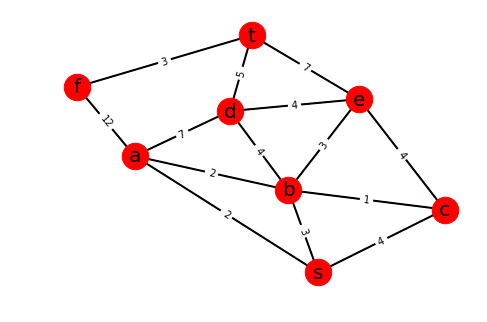

In [252]:
print_G(G)

In [47]:
rpq.df.drop_duplicates(subset = ['current_node','time_joined'], keep="first")

,current_node,distance_from_start,prev_node,time_joined,time
0,c,4.0,s,1.0,3.0
1,b,4.0,a,2.0,3.0
2,c,4.0,b,3.0,3.0
3,e,6.0,b,3.0,3.0
4,d,7.0,b,3.0,3.0
5,d,9.0,a,2.0,3.0
6,f,14.0,a,2.0,3.0
7,b,3.0,s,1.0,2.0
12,a,2.0,s,1.0,1.0
13,s,0.0,s,0.0,0.0


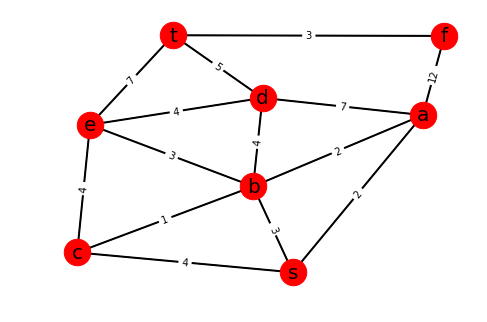

In [35]:
print_G(G)

In [ ]:
# visited = rpq.df.drop_duplicates('time').reset_index().drop('index',axis=1)
# inst = visited[visited.current_node == vrtx]
# temp_new_edges = (time_table[((time_table.V_A==vrtx) | (time_table.V_B==vrtx)) & (time_table.time_on==rpq.time)].
#                  reset_index().
#                  drop('index'
#                       ,axis=1))

In [ ]:
# rpq.time=10

In [ ]:
# for vrtx in vertex_to_check:
#     print vrtx
#     visited = rpq.df.drop_duplicates('time').reset_index().drop('index',axis=1)
#     inst = visited[visited.current_node == vrtx]
#     temp_new_edges = (time_table[((time_table.V_A==vrtx) | (time_table.V_B==vrtx)) & (time_table.time_on==rpq.time)].
#                      reset_index().
#                      drop('index'
#                           ,axis=1))

#     for i in np.arange(0,len(temp_new_edges)):
#         print i,new_vrtx,vrtx
#         if temp_new_edges.V_A.values[0]==vrtx:
#             new_vrtx = temp_new_edges.V_B.values[i]
#         else:
#             new_vrtx = temp_new_edges.V_A.values[i]
#         print i,new_vrtx,vrtx
# #             rpq.insert([new_vrtx
# #                     ,inst.distance_from_start.values[0]+temp_new_edges.weight[i]
# #                     ,vrtx
# #                     ,rpq.time
# #                     ,rpq.time
# #                    ])

In [ ]:
# temp_new_edges

In [ ]:
# temp_new_edges

In [ ]:
# vrtx='e'

In [ ]:
# (time_table[((time_table.V_A==vrtx) | (time_table.V_B==vrtx)) & (time_table.time_on==rpq.time)].
#                      reset_index().
#                      drop('index'
#                           ,axis=1))

In [ ]:
# G = nx.Graph()


# G.add_edge('o', 'a', weight=2)  
# G.add_edge('o', 'b', weight=5)
# G.add_edge('o', 'c', weight=4)

# G.add_edge('a', 'b', weight=2)  
# G.add_edge('a', 'd', weight=7)
# G.add_edge('a', 'f', weight=12)

# G.add_edge('b', 'c', weight=1)  
# G.add_edge('b', 'd', weight=4)
# G.add_edge('b', 'e', weight=3)

# G.add_edge('c', 'e', weight=4)

# G.add_edge('d', 'e', weight=4)  
# G.add_edge('d', 't', weight=5)

# G.add_edge('e', 't', weight=7)

# G.add_edge('f', 't', weight=3)



In [ ]:
# time_table[((time_table.V_A==vrtx) | (time_table.V_B==vrtx)) & (time_table.time_on==rpq.time)]

In [ ]:
# temp_new_edges = (time_table[((time_table.V_A==vrtx) | (time_table.V_B==vrtx)) & (time_table.time_on==rpq.time)].
#                          reset_index().
#                          drop('index'
#                               ,axis=1))

In [ ]:
# a = time_table.edge.values
# b = 't'
# [list(set(sublist).intersection(set(b))) for sublist in a]

In [ ]:
# G = nx.Graph()

# uniq_times = np.unique(time_table[['time_on', 'time_off']].values)[:-1]
# for i in uniq_times:
#     for edge in time_table[time_table.time_off == i].edge:
#         try:
#             G.remove_edge(edge[0], edge[1])
#             print i,'rem ', edge
#         except:
#             pass
#     for row in time_table[time_table.time_on == i].iterrows():
#         print i,'add ', row[1][0]
#         G.add_edge(row[1][0][0], row[1][0][1],weight = row[1][3])
        
#     print_G(G)

In [ ]:
# G = nx.Graph()


# G.add_edge('s', 'a', weight=2)  
# G.add_edge('s', 'b', weight=5)
# G.add_edge('s', 'c', weight=4)

# G.add_edge('a', 'b', weight=2)  
# G.add_edge('a', 'd', weight=7)
# G.add_edge('a', 'f', weight=12)

# G.add_edge('b', 'c', weight=1)  
# G.add_edge('b', 'd', weight=4)
# G.add_edge('b', 'e', weight=3)

# G.add_edge('c', 'e', weight=4)

# G.add_edge('d', 'e', weight=4)  
# G.add_edge('d', 't', weight=5)

# G.add_edge('e', 't', weight=7)

# G.add_edge('f', 't', weight=3)

In [ ]:
# rpq = RPQ()

In [ ]:
# current_node, current_tot_weight = rpq.pop_current_node()
# print current_node,current_tot_weight
# rpq.add_visited(current_node) ## note that this node has been visited
# rpq.increase_time() ## increase timer by 1

# current_connections = list(G.adj[current_node])
# rpq.add_timestep()

# for node in list(set(current_connections).difference(rpq.visited)):
#     print current_node,node,+G[current_node][node].values()[0]
#     rpq.insert([node
#                 ,current_tot_weight+G[current_node][node].values()[0]
#                 ,current_node
#                 ,rpq.time
#                 ,rpq.time
#                ])
# rpq.de_dup()
